# Build a Neural Network from Scratch

In this post, we'll walk through how to build a simple neural network from scratch using just NumPy. No high-level libraries like TensorFlow or PyTorch, just the fundamentals.

---

## What *is* a Neural Network?

A neural network is a set of interconnected layers of simple computational units called **neurons**. Each neuron receives inputs and returns an output value.
It does this by multiplying each input by a learned weight and adding adds a bias term. The resulting value is then passed through a  nonlinear activation function. We'll explain later why this last step is necessary.

If the activation function is a **sigmoid**, a single neuron is essetially a **logistic regression** function: given multiple inputs returns a probability between 0 and 1.

The real power of neural networks comes from stacking many of these simple neurons into **layers** and then chaining layers together by connecting the outputs of one layer to the inputs of another. This composition allows the network to learn increasingly complex patterns, a process often referred to as **automatic feature engineering**.
So instead of manually designing features like we have seen in a previous pose the model can automatically learn them provided there is enought training data and the model is sufficiently complex.

A classic example of this is image classification. The first layer might learn to detect edges, the next layer might learn to combine those edges into shapes, and subsequent layers might learn to recognize more complex patterns like objects or faces.

![](facial_recognition.png)
(source: Zhanli Liu)

We can use neural networks to approximate virtually any function. That's why neural networks are called **universal function approximators**.

---


## Architecture

We'll define the neural networks as a series of different `Layer`'s.

Each layer has:

* A **weight matrix** connecting inputs to outputs,
* A **bias vector**,
* An optional **activation function** (e.g., ReLU, Sigmoid, Tanh).


During the **forward pass**, the layer computes:

```python
z = input @ weights + bias
a = activation(z)
```
In the **backward pass**, we improve the model performance by adjusting the weights and biases slightly. First, we compute the **loss**, a measure of how far off the model’s guess was. Then we calculate the **gradient of the loss**, which tells us how much each part of the output contributed to that error.

We propagate this gradient backward through the network, layer by layer, figuring out how much each **weight** and **bias** contributed to the final output. Using this information, we update the weights and biases to reduce the loss. Each layer also calculates how much its inputs contributed to the output, and passes that information to the layer before it. This way, the entire network learns to make better predictions over time.

### Why does this work?

We can do this because of the chain rule:
$$
    F(x) = f(g(x)) 
$$
$$
    F'(x) = f'(g(x)) \cdot g'(x)
$$

So if we imagine $f$ is the loss funciton and $g$ is the model, we can compute the gradient of the loss function
 with respect to the model's input, by first computing the gradient of the loss with respect to the models’s output ($f'(y)$ where $y=g(x)$), then multiplying that by the gradient of the model with respect to its input ($g'(x)$).
Also notice that we already computed $y$ in the forward pass, so if we just keep track of the result instead of recompute it in the backwards pass. 

This priciple can be applied recursively since the model is just a series of layers. The gradient of the full model can again be decomposed into the gradient of the last layer with respect to the previous layers output times the gradient of all previous layers with respect to the models inputs. When we fully decompose the model this way we have arrrived at our impelemntaion of the backwards pass.

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tqdm

In [138]:
class Layer:
    def __init__(self, input_size, output_size, activation=None):
        self.weights = np.random.normal(scale=np.sqrt(1/input_size), size=(input_size, output_size))
        self.bias = np.zeros((1, output_size))
        if activation is None:
            self.activation = None
        else:
            self.activation = activation()

    def forward(self, x):
        self.input = x
        self.z = x @ self.weights + self.bias  # pre-activation output
        if self.activation is not None:
            self.a = self.activation.forward(self.z)
            return self.a
        return self.z

    def backward(self, d_output, learning_rate):
        # If activation is present, backprop through it first
        if self.activation is not None:
            d_output = self.activation.backward(d_output)

        d_weights = self.input.T @ d_output
        d_bias = np.sum(d_output, axis=0, keepdims=True)
        d_input = d_output @ self.weights.T

        # Update parameters
        self.weights -=  learning_rate * d_weights
        self.bias -= learning_rate * d_bias

        return d_input



### Activation Functions
Why do we need non-linear activaiton functions?
Because otherwise each layer is a linear operation. And stacking multiple linear operations still results in an overall linear operation. This means we don't gain complexity by making our model more deep. Non-linearities like ReLU, Tanh, and Sigmoid prevent this and let the network learn complex patterns and approximate any function.

**ReLU** (`f(x) = max(0, x)`) is the most commonly used. It's fast, works well in deep networks, and avoids vanishing gradients for positive inputs. However, some neurons can "die" and stop updating if they get stuck on the negative side.

**Tanh** outputs values between -1 and 1, which centers the data and can help with convergence. But like sigmoid, it still suffers from vanishing gradients at the extremes.

**Sigmoid** squashes inputs to the range \[0, 1], making it intuitive for binary outputs. It's rarely used in hidden layers today due to slow learning and saturation issues but remains useful in binary classification output layers.

In [ ]:
class Relu:
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)

    def backward(self, d_output):
        return d_output * (self.input > 0)

class Tanh:
    def forward(self, x):
        self.output = np.tanh(x)
        return self.output

    def backward(self, d_output):
        return d_output * (1 - self.output ** 2)


class Sigmoid:
    def forward(self, x):
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, d_output):
        return d_output * (self.output * (1 - self.output))


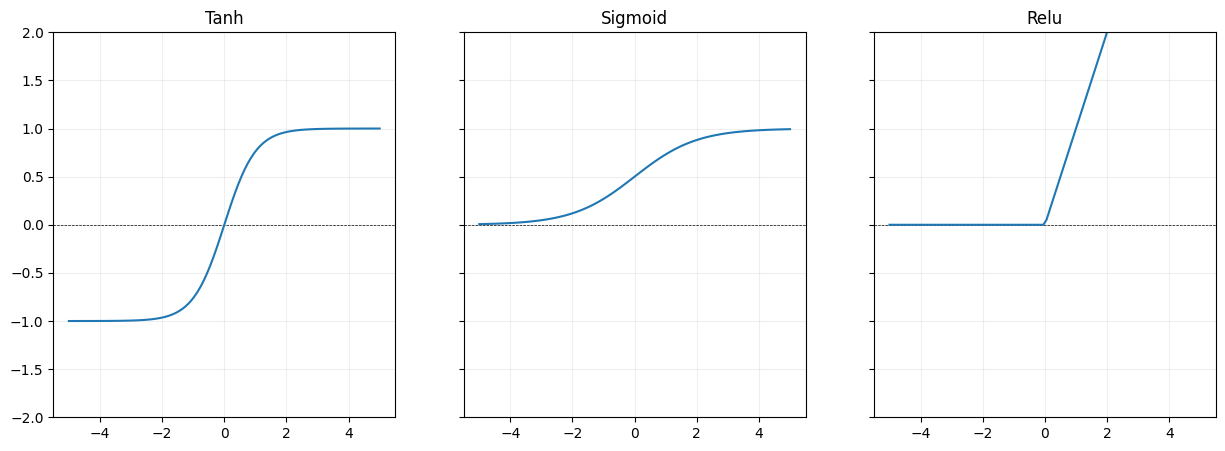

In [167]:
plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, activation in enumerate([Tanh, Sigmoid, Relu]):
    x = np.linspace(-5, 5, 100)
    y = activation().forward(x)
    plt.subplot(1, 3, i + 1)
    plt.title(activation.__name__)
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.ylim(-2,2)
    plt.grid(True, alpha=0.2)
    plt.plot(x, y, label=activation.__name__)

## Putting it all together
The `NeuralNetwork` class brings everything together—it’s the main model that chains multiple layers to form a complete feedforward neural network. It takes care of creating the input layer, a stack of hidden layers, and the output layer, each with their own activation functions. During training, we call `forward()` to compute predictions and `backward()` to update the weights based on the loss. This class is the high-level structure that lets us switch between tasks like regression or classification just by changing layer sizes and activations, without rewriting any of the core logic.


In [17]:
class NeuralNetwork:
    def __init__(self, input_size, output_size, hidden_layer_size, num_hidden_layers, head_activation=None, hidden_activation=Relu):
        self.layers = []

        # first hidden layer (input layer) 
        self.layers.append(Layer(input_size, hidden_layer_size, activation=hidden_activation))
        
        # Hidden layers
        for _ in range(num_hidden_layers - 1):
            self.layers.append(Layer(hidden_layer_size, hidden_layer_size, activation=hidden_activation))

        #output layer
        self.layers.append(Layer(hidden_layer_size, output_size, activation=head_activation))

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, loss_grad, learning_rate):
        for layer in reversed(self.layers):
            loss_grad = layer.backward(loss_grad, learning_rate)

## Training
To train the model we define a Loss function and a fairly standard training loop. For regression we'll use MeanSquaredError Loss.

In [2]:
class MeanSquaredErrorLoss:
    @staticmethod
    def loss(y_pred, y_true):
        return np.mean(np.square(y_pred - y_true))

    @staticmethod
    def grad(y_pred, y_true):
        return 2 * (y_pred - y_true) / y_true.shape[0]

In [170]:
def train(model, X_train, y_train, loss_fn, epochs, batch_size, learning_rate, X_test=None, y_test=None, bar=True):
    train_losses = []
    eval_losses = []

    if bar:
        pbar = tqdm.tqdm(total=epochs, desc="Training Progress", position=0)

    for epoch in range(epochs):
        permutation = np.random.permutation(X_train.shape[0])
        X_shuffled = X_train[permutation]
        y_shuffled = y_train[permutation]
    
        losses = []
        grads = []
    
        for i in range(0, X_train.shape[0], batch_size):
            x_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            y_pred = model.forward(x_batch)
            loss = loss_fn.loss(y_pred, y_batch)
            losses.append(loss)
            grad = loss_fn.grad(y_pred, y_batch)
            grads.append(np.mean(np.abs(grad)))
            
            model.backward(grad, learning_rate)
    
    
        train_loss = np.mean(losses)
        train_losses.append(train_loss)
        avg_grad = np.mean(grads)
        if X_test is not None and y_test is not None:
            eval_loss = loss_fn.loss(model.forward(X_test), y_test)
            eval_losses.append(eval_loss)
        else:
            eval_loss = None
        if bar:
            pbar.update(1)
            pbar.set_postfix(train_loss=train_loss, eval_loss=eval_loss, avg_grad=avg_grad)
    return train_losses, eval_losses

We can test our model as a universal function approximator. Here we define a few non-linear function we want our model to approximate. We setup a fairly small model (2 hidden layers with size 32), the hidden_activation_function is tanh and we have no head activation, since we to want to project values to any possible value on the y axis.

Training Progress: 100%|█████████████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 366.81it/s, avg_grad=0.00964, eval_loss=None, train_loss=0.0927]


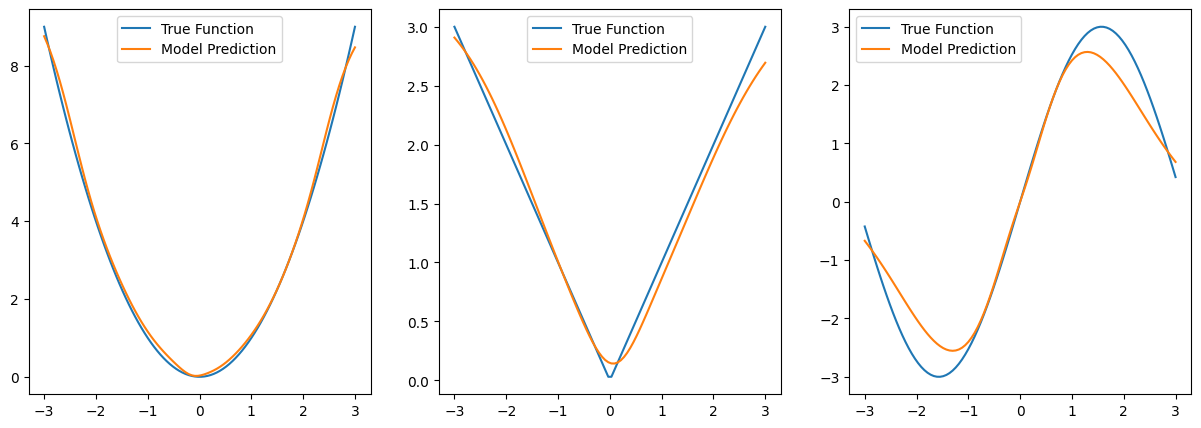

In [176]:
functions = [lambda x: x**2, lambda x: abs(x), lambda x: 3*np.sin(x)]

plt.figure(figsize=(15, 5))

for i, fn in enumerate(functions):
    X = np.linspace(-3, 3, 100).reshape(-1, 1)
    y = fn(X)
    model = NeuralNetwork(input_size=1, output_size=1, hidden_layer_size=32,  num_hidden_layers=2, hidden_activation=Tanh)
    train(model, X, y, loss_fn=MeanSquaredErrorLoss, epochs=400, batch_size=64, learning_rate=0.05)
    plt.subplot(1, 3, i + 1)
    plt.plot(X, y, label='True Function')
    plt.plot(X, model.forward(X), label='Model Prediction')
    plt.legend()


We see the model's prediction (orange) roughtly follow the true function in blue

### Classification

Neural networks are also great for classification tasks. To demonstrate this, we'll use the classic MNIST dataset—a collection of thousands of 28x28 pixel images of handwritten digits from 0 to 9. The goal is to correctly identify which digit is shown in each image.


In [177]:
# Load data
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target'].astype(int)

# Normalize input
X = X / 255.0
X = X.to_numpy()

# One-hot encode targets
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.to_numpy().reshape(-1, 1))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


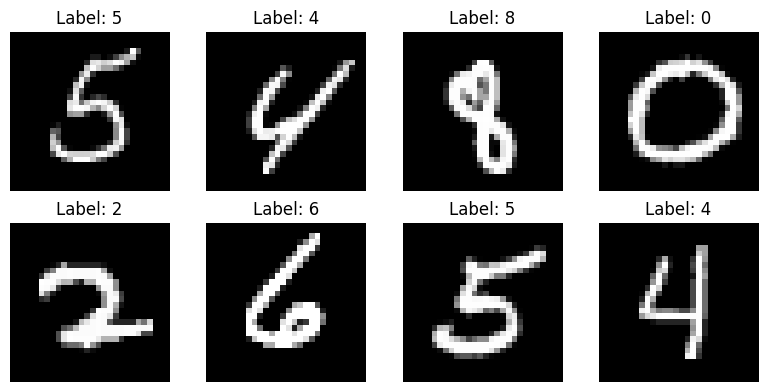

In [178]:
def show_mnist_samples(X, y, y_pred=None, num_samples=8):
    plt.figure(figsize=(8, 4))
    for i in range(num_samples):
        plt.subplot(2, 4, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        if y_pred is not None:
            plt.title(f"Label: {np.argmax(y[i])}\nPred: {y_pred[i]}")
        else:
            plt.title(f"Label: {np.argmax(y[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_mnist_samples(X_train, y_train, num_samples=8)

For classification, we can't just return raw values. We use the softmax activation function, which turns the output into probabilities across the classes. This makes it possible to interpret the model’s prediction as a confidence score for each digit. We then use cross-entropy loss, which works well with probability outputs and is the standard choice for multi-class classification problems.

In [179]:
class Softmax:
    def forward(self, x):
        # Stability trick: subtract max
        x_stable = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x_stable)
        self.output = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.output

    def backward(self, d_output):
        # Placeholder, won't be used since we'll derive directly from cross-entropy
        return d_output

In [180]:
class CrossEntropyLoss():
    @staticmethod
    def loss(y_pred, y_true):
        # Avoid log(0)
        epsilon = 1e-12
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
    @staticmethod
    def grad(y_pred, y_true):
        # Gradient of softmax + cross-entropy
        return (y_pred - y_true) / y_true.shape[0]

We set up the model with 784 inputs (the number of pixels in each image) and an output size of 10 (the number of classes). For the hidden activation we choose Relu and the Head activation is Softmax as we said earlier.

In [182]:
nn = NeuralNetwork(
    input_size=784,
    output_size=10,
    hidden_layer_size=32,
    num_hidden_layers=2,
    hidden_activation=Relu,
    head_activation=Softmax
)
train_losses, eval_losses = train(nn, X_train, y_train, X_test=X_test, y_test=y_test, loss_fn=CrossEntropyLoss, epochs=40, batch_size=64, learning_rate=0.05)

Training Progress: 100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.20it/s, avg_grad=5.26e-5, eval_loss=0.143, train_loss=0.0283]


When we plot the train and evaluation loss, we can see that evaluation loss platous pretty quickly, but training loss continues to go down. If we keep going too long we will overfit to our training data.

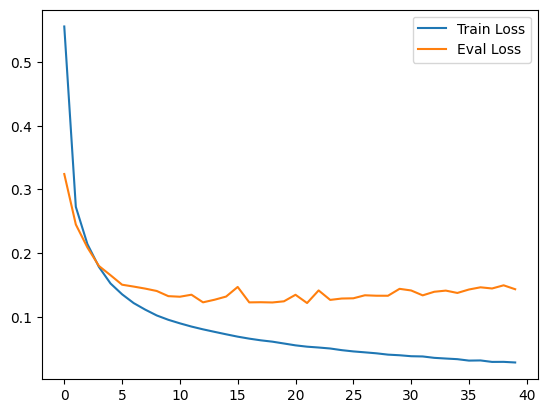

In [183]:
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Eval Loss')
plt.legend()

Performance is pretty good. Our neural network is able to predict the correct digit in the evaluation set with 97% accuracy

In [184]:
def accuracy(model, X, y_true):
    y_pred = model.forward(X)
    pred_labels = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y_true, axis=1)
    return np.mean(pred_labels == true_labels)

print("Train accuracy:", accuracy(nn, X_train, y_train))
print("Test accuracy:", accuracy(nn, X_test, y_test))

Train accuracy: 0.9944642857142857
Test accuracy: 0.9665714285714285


We can display the 10-dimensional output of the model using t-SNE - a popular visualization technique for highdimensional data. It will project the output down to 2 dimensions but tries to preserve clusters. Doing this we can see nice groups for each class in the test set. Notice how similar looking number like 4 and 9 appear closer to each other.

In [185]:
def extract_features(model, X):
    """Run forward pass and extract activations from the last hidden layer."""
    x = X
    # Forward pass through all layers except last (softmax) to get last hidden features
    for layer in model.layers[:-1]:
        x = layer.forward(x)
    return x

features = extract_features(nn, X_test)

# Run t-SNE on features (shape: [num_samples, hidden_layer_size])
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Get predicted classes
y_pred = nn.forward(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)


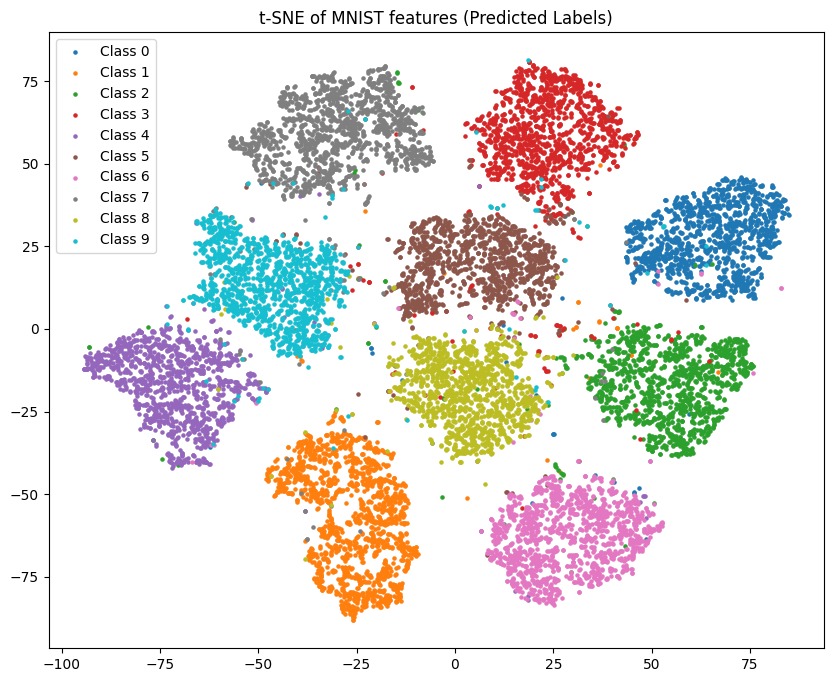

In [186]:
plt.figure(figsize=(10, 8))

for label in np.unique(y_pred_labels):
    plt.scatter(features_2d[y_pred_labels == label, 0], features_2d[y_pred_labels == label, 1], label=f'Class {label}', s=5)
    
plt.title('t-SNE of MNIST features (Predicted Labels)')

plt.legend()
plt.show()

Finally we can look at a few of the samples, where our neural network guessed wrong. Most of these misclassifications are understandable and can be attributed to sloppy handwriting. An accuracy of 97% is still really good for a simple model like this.

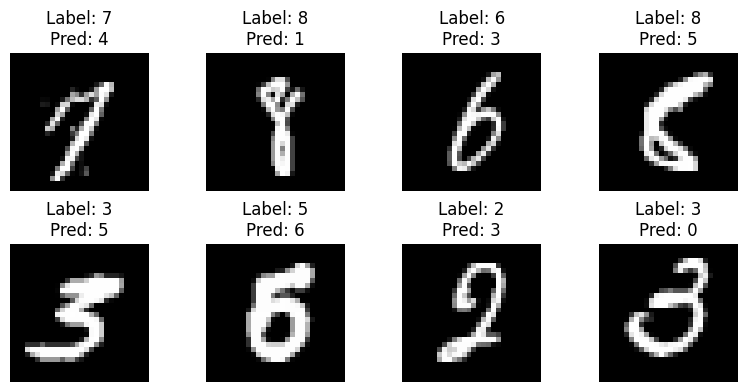

In [187]:
y_pred = nn.forward(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
misclassified_idx = np.where(y_pred_labels != y_true_labels)[0]
idx = np.random.choice(misclassified_idx, size=8, replace=False)

show_mnist_samples(X_test[idx], y_test[idx], y_pred_labels[idx], num_samples=8)